In [6]:
import torch
import gym
import numpy as np
import torch.nn as nn
from copy import deepcopy as dpc
from random import sample
import pygame
from tqdm import tqdm, trange
import random

In [2]:


class DQN(nn.Module):
    def __init__(self, n_actions, in_shape, hidden_size, hidden_size_2):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_shape, hidden_size),
            nn.ReLU(inplace=False),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(inplace=False),
            nn.Linear(hidden_size_2, n_actions)
        )

        
    
    def forward(self, X):
        return self.net(X)

    
class Agent():
    def __init__(self, n_actions, n_state, lr, batch_size, hidden_size, hidden_size_2, MAX_MEM):
        self.model = DQN(n_actions, n_state, hidden_size,hidden_size_2)
        self.model_prime = DQN(n_actions, n_state, hidden_size,hidden_size_2)
        self.MAX_MEM = MAX_MEM
        self.state_buffer = np.zeros((MAX_MEM, n_state), dtype=np.float32)
        self.next_state_buffer = np.zeros((MAX_MEM, n_state), dtype=np.float32)
        self.eps = 1.0
        self.n_actions = n_actions
        self.batch_size = batch_size

        self.action_buffer = np.zeros(MAX_MEM, dtype=np.int32)
        self.reward_buffer = np.zeros(MAX_MEM, dtype=np.float32)
        self.is_terminal_buffer = np.zeros(MAX_MEM, dtype=np.bool8)

        self.mem_ptr = 0
        self.when_copy = 4

        self.loss_fn = nn.HuberLoss()
        self.optim = torch.optim.Adam(self.model.parameters(), lr=0.003)

    def set_buffer_states(self, state, action, reward, next_state, terminal):
        idx= self.mem_ptr % self.MAX_MEM
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.next_state_buffer[idx] = next_state
        self.is_terminal_buffer[idx] = terminal

        self.mem_ptr+=1
    
    def action_selection(self, state):
        
        if random.random() > self.eps:
            out = self.model(torch.Tensor(state))
            return torch.argmax(out).item()
        else:
            return random.randint(0, self.n_actions-1)

    def learn(self):        
        if self.mem_ptr < self.batch_size:
            return
        self.optim.zero_grad()
        max_mem = min(self.mem_ptr, self.MAX_MEM)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = torch.Tensor(self.state_buffer[batch])
        next_state_batch = torch.Tensor(self.next_state_buffer[batch])
        reward_batch = torch.Tensor(self.reward_buffer[batch])
        action_batch = self.action_buffer[batch]
        is_terminal_batch = self.is_terminal_buffer[batch]

        q_eval = self.model(state_batch)[batch_index, action_batch]
        # print(q_eval.shape)
        q_next = self.model(next_state_batch)
        q_next[is_terminal_batch] = 0.0

        target = reward_batch + (0.99  * torch.max(q_next))

        loss = self.loss_fn(target, q_eval)
        loss.backward()

        self.optim.step()

        self.eps = self.eps - 5e-4 if (self.eps - 5e-4 ) > 0.01 else 0.01
        # if self.when_copy == 0:
        #     self.when_copy = 4
        #     self.model_prime.load_state_dict(self.model.state_dict())
        # self.when_copy -=1
            




In [3]:
agent = Agent(4,8,0.003,64, 256, 256, 10000)

In [4]:
env = gym.make("LunarLander-v2", render_mode="human")
scores = []


for ep in (pbar:=tqdm(range(1000))):
    observation, info = env.reset(seed= 42)
    done = False
    truncated = False
    score = 0.0
    
    while not done and not truncated:
        action = agent.action_selection(observation)
        observation_new, r, term, trunc, info = env.step(action)
        score +=r
        
        agent.set_buffer_states(observation, action, r, observation, term)
        agent.learn()
        observation = observation_new
        done = term
        truncated = trunc
    scores.append(score)
    pbar.set_description("Eps: {:.3} Score: {:.3}".format(agent.eps, score))
env.close()
pygame.quit()
torch.save(agent, "agent.pt")
torch.save(scores, "scores.pt")

Eps: 0.01 Score: -73.0: 100%|██████████| 1000/1000 [1:46:52<00:00,  6.41s/it]     


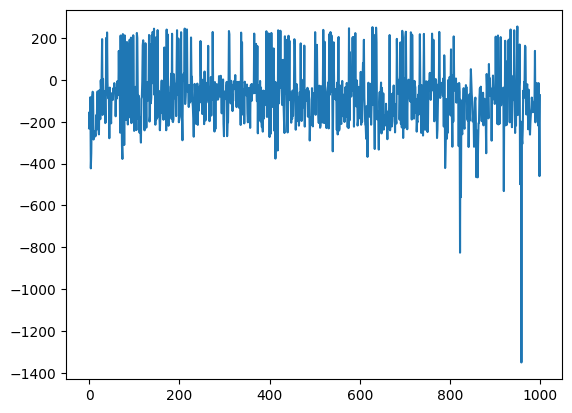

In [5]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [ ]:
torch.save(agent, "agent.pt")